In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd 
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.impute import KNNImputer, SimpleImputer
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
df = pd.read_csv("diabetes.csv")

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
print("Number of Rows", df.shape[0])
print("Number of Columns", df.shape[1])

Number of Rows 768
Number of Columns 9


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


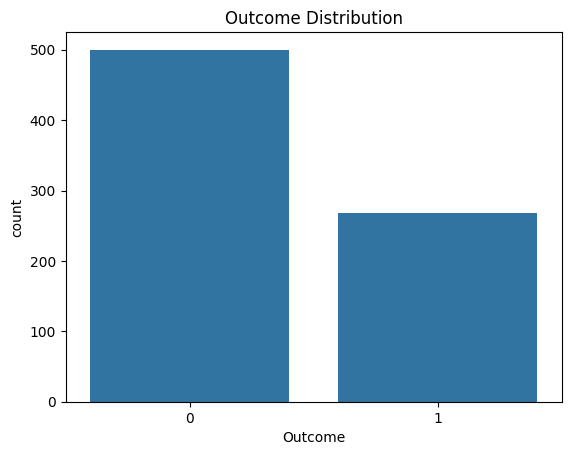

In [7]:
sns.countplot(x = "Outcome", data = df)
plt.title("Outcome Distribution")
plt.show;

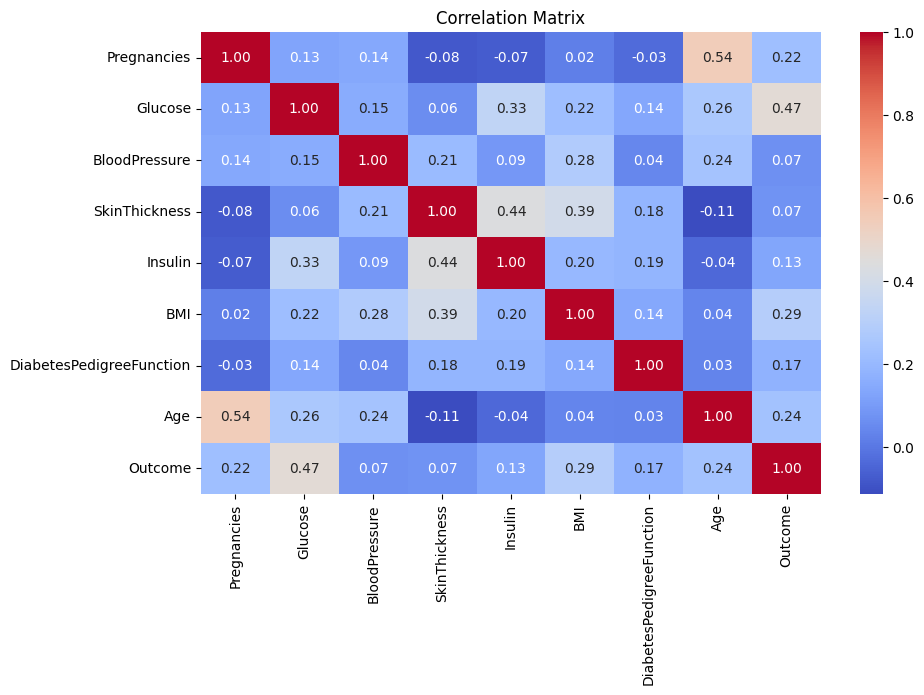

In [8]:
correlation_matrix = df.corr()
plt.figure(figsize= (10,6))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title("Correlation Matrix")
plt.show;

**Handling Missing Values**

In [9]:
zero_counts = (df == 0).sum()

In [10]:
columns_with_zeros = zero_counts[zero_counts > 0]
print("Columns with counts of 0")
print(columns_with_zeros)

Columns with counts of 0
Pregnancies      111
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
Outcome          500
dtype: int64


In [11]:
total_zeros_per_column = columns_with_zeros.sum()
print("\nTotal number of zeros per column:")
print(total_zeros_per_column)

# 3. Calculate the percentage of rows with at least one zero in each column
rows_with_zero = (columns_with_zeros > 0).any()
percentage_rows_with_zero = (rows_with_zero * 100 / len(df))
print("\nPercentage of rows with at least one zero in each column:")
print("{}%".format(round(percentage_rows_with_zero,  2)))



Total number of zeros per column:
1263

Percentage of rows with at least one zero in each column:
0.13%


The missing values in each row are:

Pregnancies      111

Glucose            5

BloodPressure     35

SkinThickness    227

Insulin          374

BMI               11

**KNN IMPUTATION**

In [12]:
columns_with_zeros = ['Pregnancies',"Glucose", 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

#replace the zeros with nans
df[columns_with_zeros] = df[columns_with_zeros].replace(0, np.nan)

#initiate the imputer
imputer = KNNImputer(n_neighbors=5)

#fit the data
df[columns_with_zeros] = imputer.fit_transform(df[columns_with_zeros])

print("Count of 0 values after imputation:")

print(df[columns_with_zeros].eq(0).sum())

Count of 0 values after imputation:
Pregnancies      0
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


**Handling Outliers**

In [13]:
#create a function to handle the outliers using z score
#column: The name of the column in the DataFrame on which outlier detection and handling will be performed.
#threshold: The threshold value for identifying outliers. By default, it is set to 3 standard deviations from the mean.
def handle_outliers_zscore (df, column, threshold = 3): 
    z_scores = zscore(df[column])
    outliers = (z_scores > threshold) | (z_scores <  -threshold)
    
    df.loc[outliers, column] = df[column].mean() # replace outlier values with mean of that column
 # replace outlier values with mean of that column
    return df

#It defines a boolean mask outliers where True values represent the positions of outliers. 
# These outliers are identified based on whether their Z-score exceeds the specified threshold value (threshold) in either direction (positive or negative).

In [14]:
# iterate over all numerical columns in the DataFrame and apply the handle_outliers_zscore function to each column, effectively handling outliers in all numerical columns of the DataFrame.
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
for column in numerical_columns:
    df = handle_outliers_zscore(df, column)

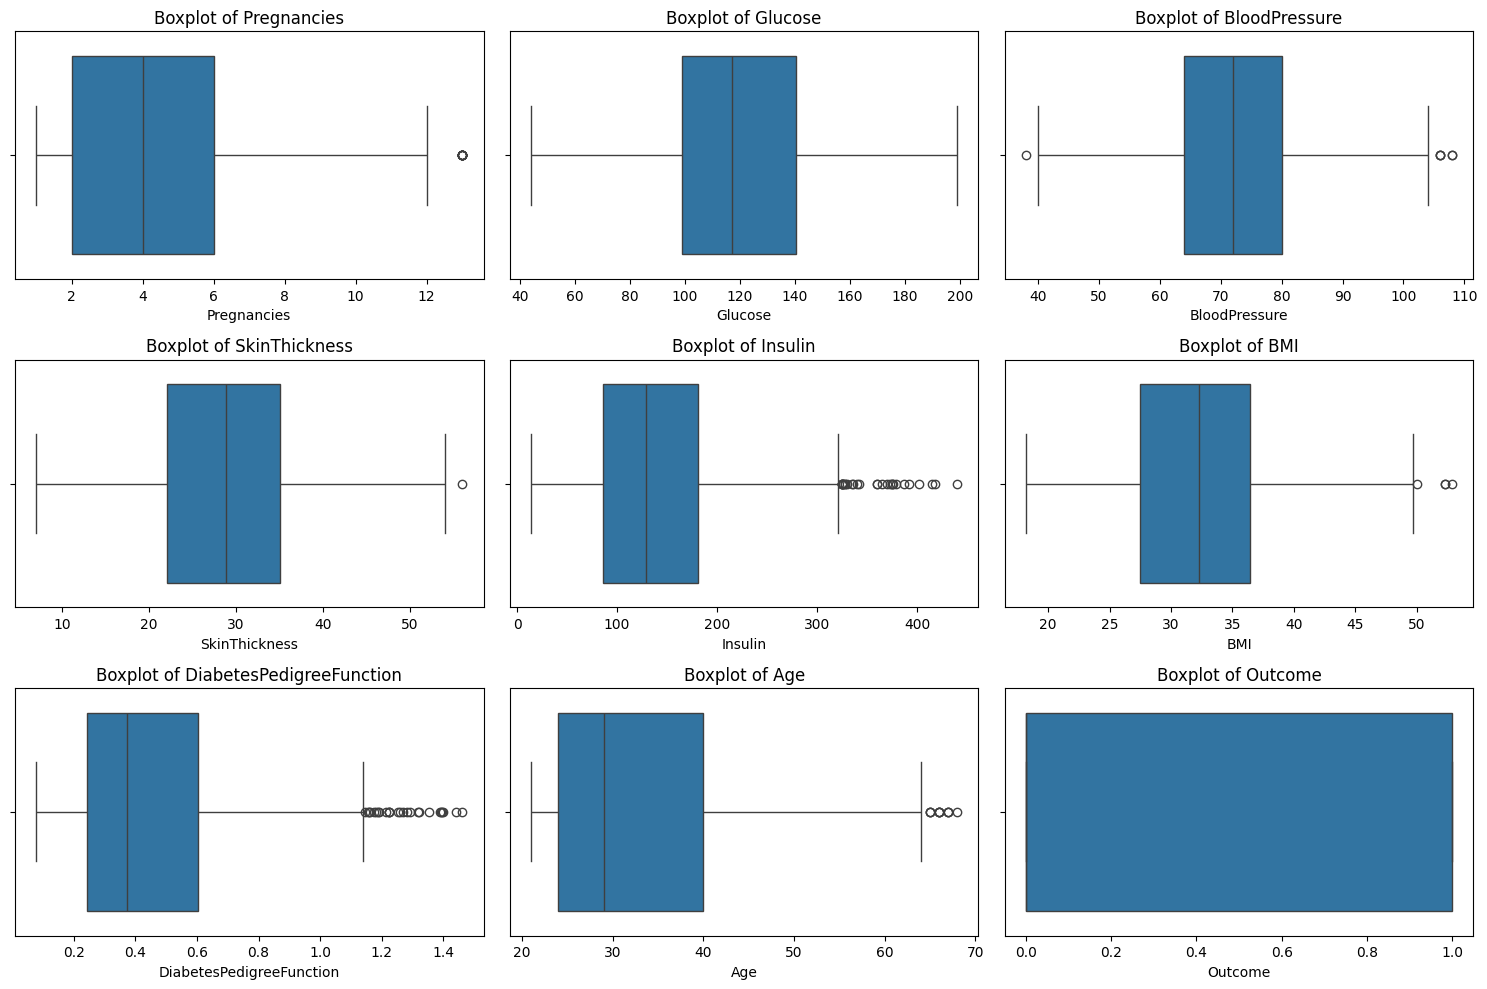

In [15]:
plt.figure(figsize=(15,10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3,3,i)
    sns.boxplot(x = df[column])
    plt.title(f"Boxplot of {column}")
    
plt.tight_layout()
plt.show;

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x1000 with 0 Axes>

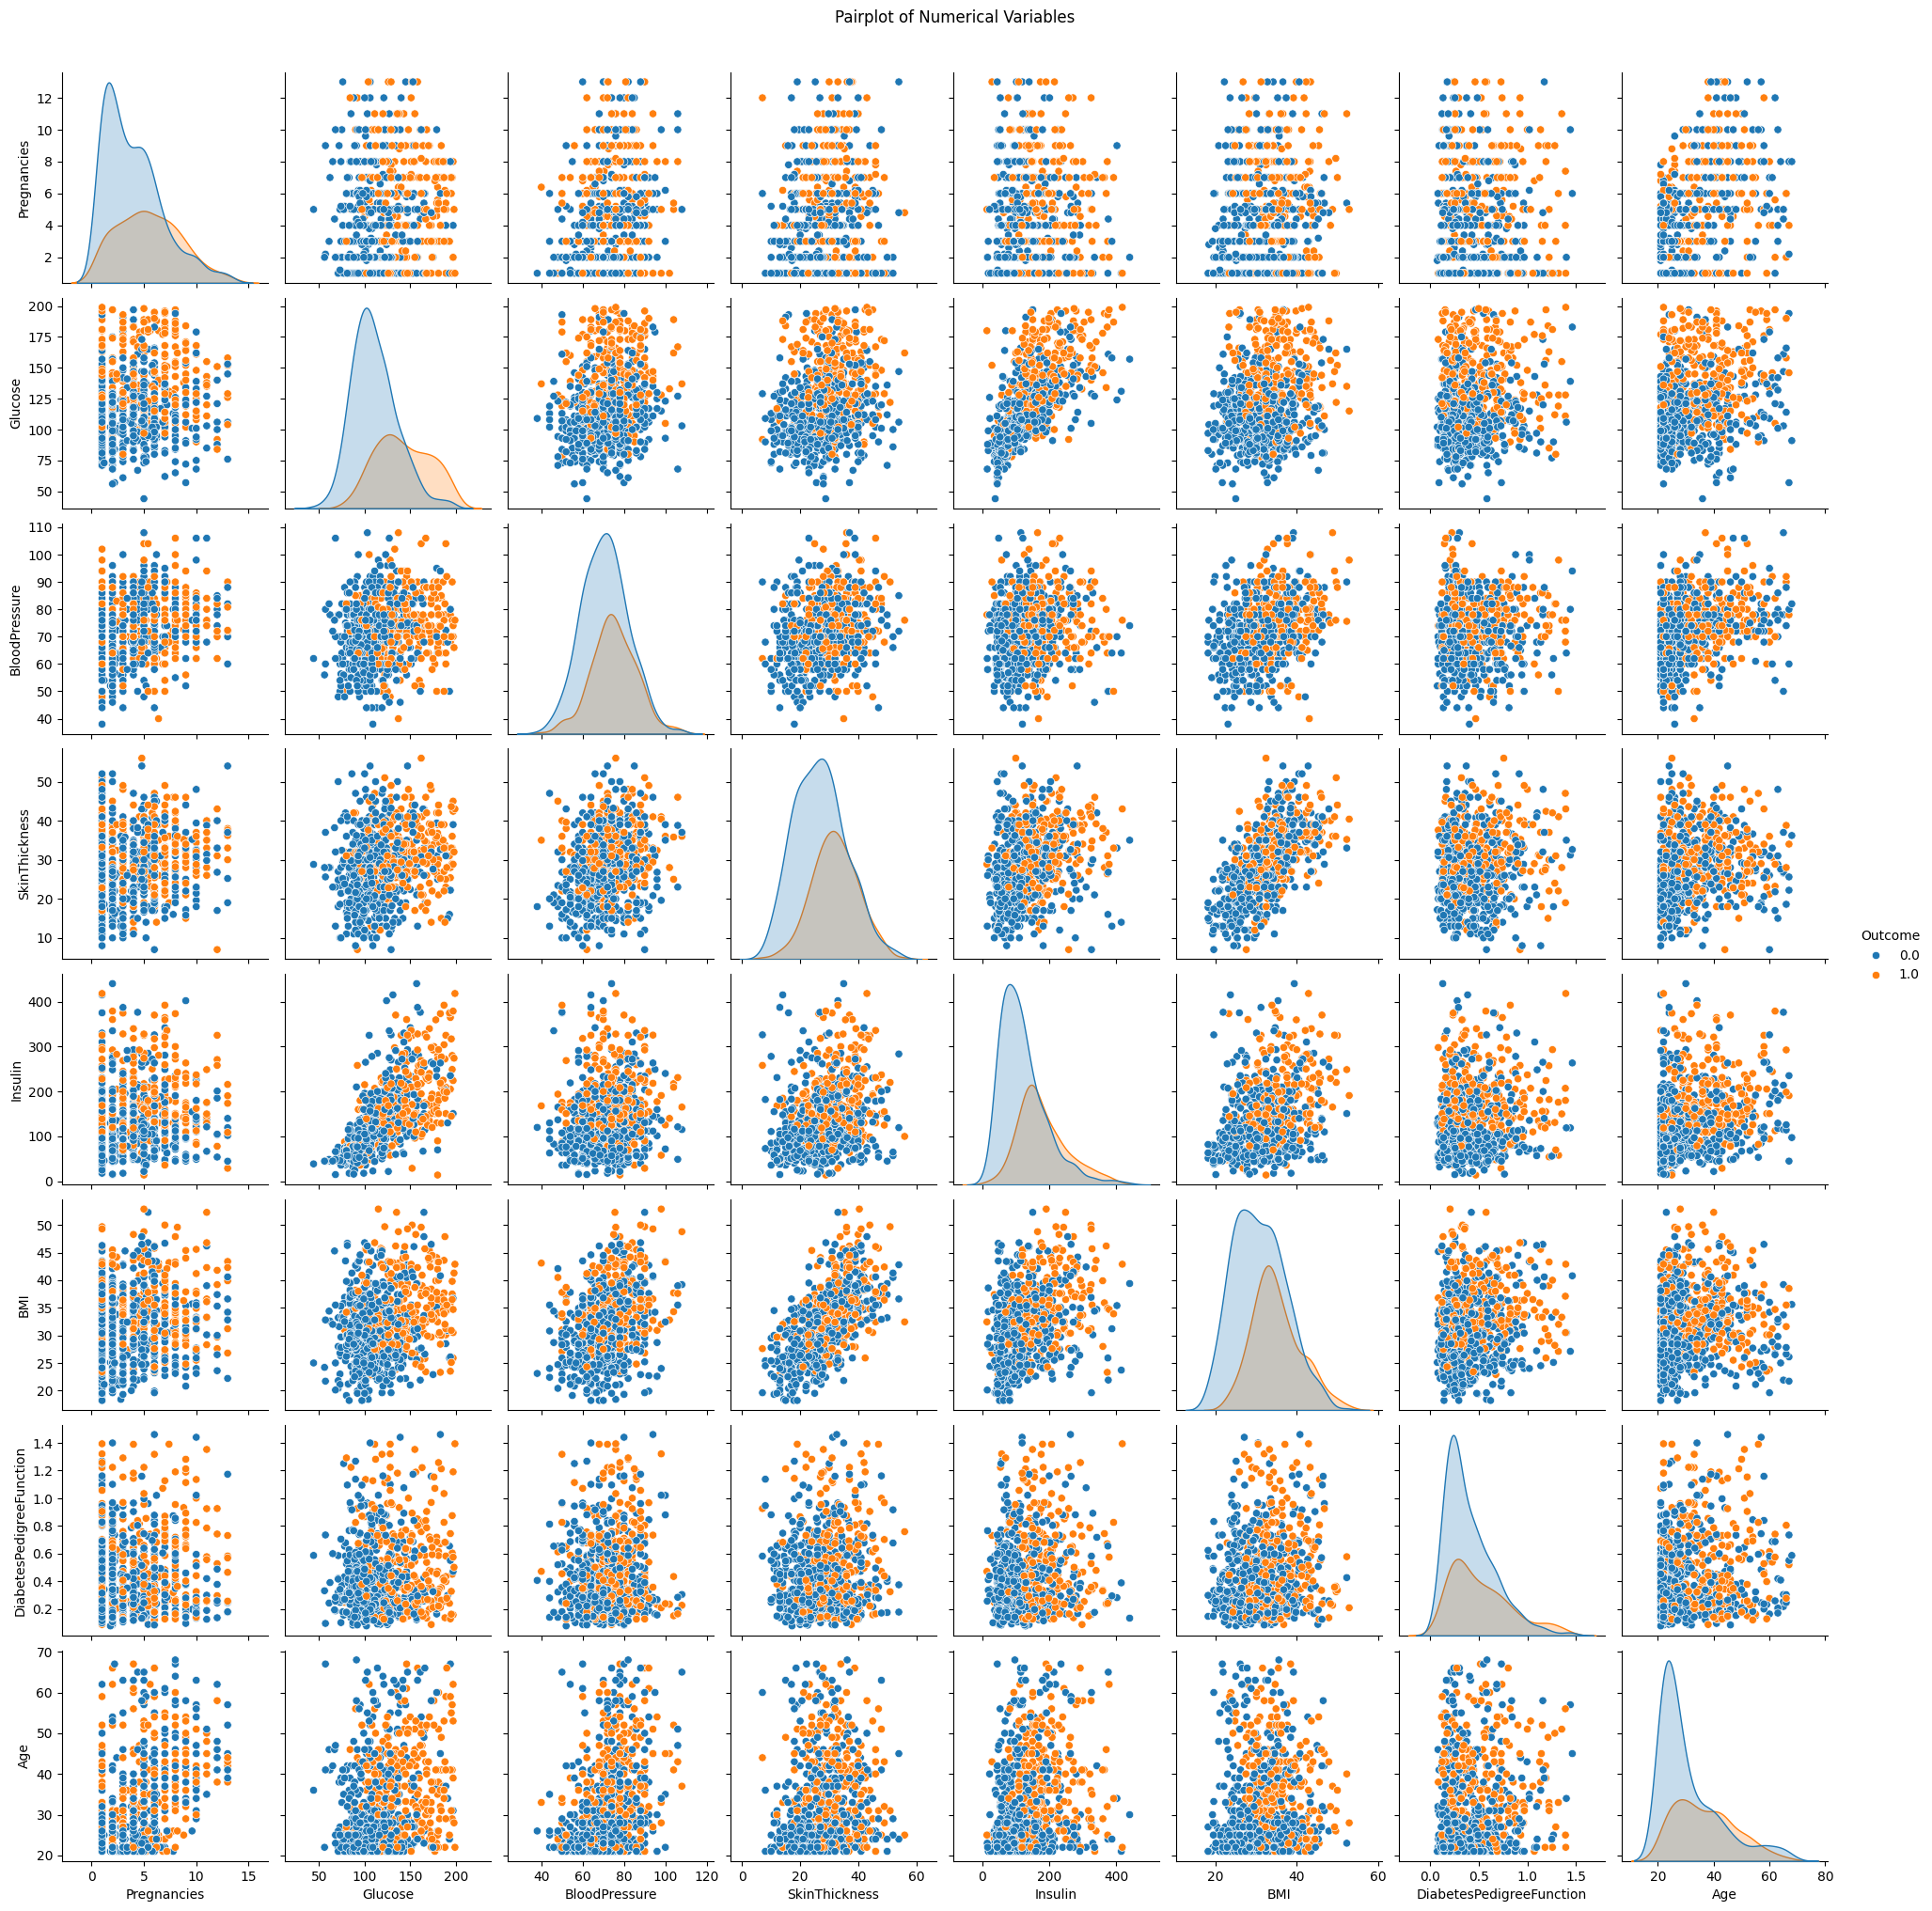

In [16]:
plt.figure(figsize=(12, 10))

sns.pairplot(df, hue='Outcome', diag_kind='kde', height=2.5)
plt.suptitle('Pairplot of Numerical Variables', y=1.02)
plt.show();

**SMOTE resampling**

In [17]:
X = df.drop("Outcome", axis = 1)
y = df['Outcome']

In [18]:
smote = SMOTE(random_state = 42)
X_resampled, Y_resampled = smote.fit_resample(X, y)

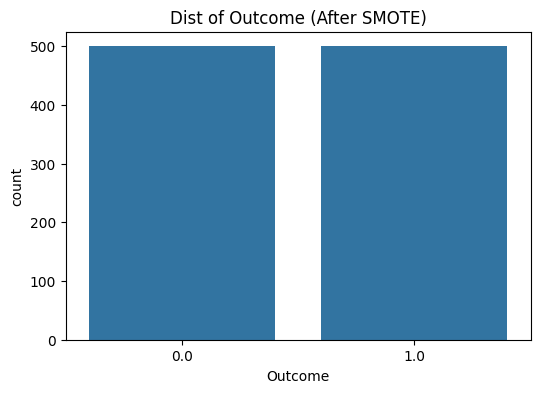

In [19]:
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(Y_resampled, name = "Outcome")], axis=1)

plt.figure(figsize=(6,4))
sns.countplot(x="Outcome", data = df_resampled)
plt.title("Dist of Outcome (After SMOTE)")
plt.show();

**MODELS**

In [20]:
#using the resampled df

X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=(1-0.8), random_state=42)

Random Forest Classifier

In [21]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [22]:
rf_accuracy = accuracy_score(y_test, rf_pred)

In [23]:
rf_report = classification_report(y_test, rf_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

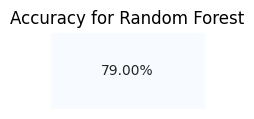

In [24]:
plt.figure(figsize=(2,1))
sns.heatmap([[rf_accuracy]], annot=True, fmt = ".2%", cmap='Blues',cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title("Accuracy for Random Forest")
plt.show();

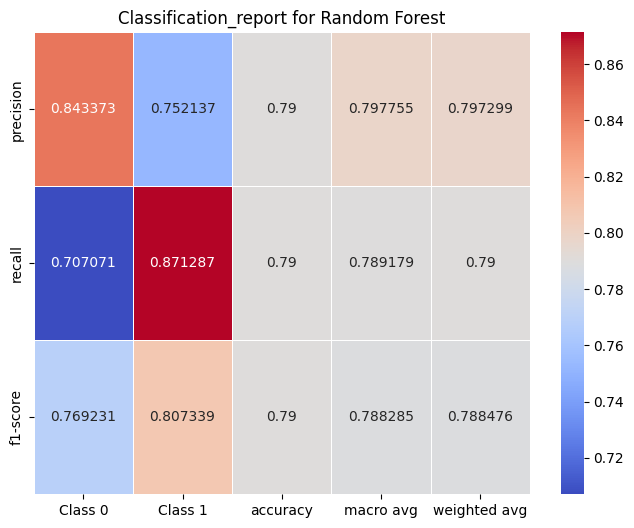

In [25]:
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(rf_report).iloc[:-1, :], annot=True, cmap = 'coolwarm', fmt='g', linewidths=.5)
plt.title("Classification_report for Random Forest")
plt.show();

KNN

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [27]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)

In [28]:
knn_accuracy = accuracy_score(y_test, knn_pred)

In [29]:
knn_report = classification_report(y_test, knn_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

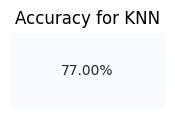

In [30]:
plt.figure(figsize=(2,1))
sns.heatmap([[knn_accuracy]], annot=True, fmt = ".2%", cmap='Blues',cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title("Accuracy for KNN")
plt.show();

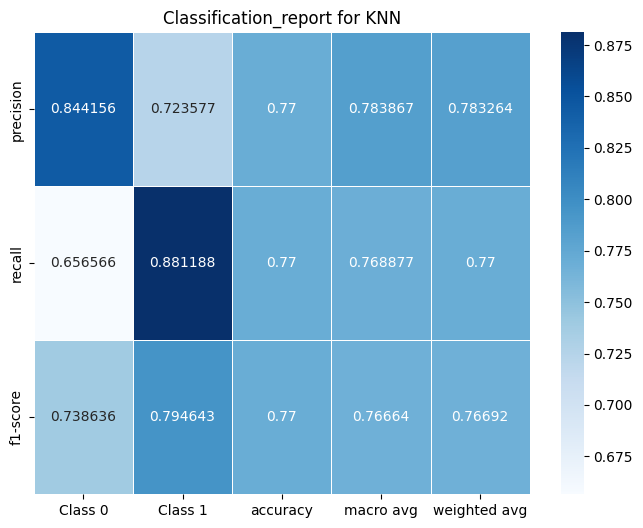

In [31]:
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(knn_report).iloc[:-1, :], annot=True, cmap = 'Blues', fmt='g', linewidths=.5)
plt.title("Classification_report for KNN")
plt.show();

SVM

In [32]:
svm_model = SVC(kernel = 'rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)

In [33]:
svm_accuracy = accuracy_score(y_test, svm_pred)

In [34]:
svm_report = classification_report(y_test, svm_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

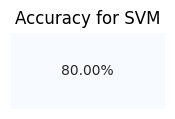

In [35]:
plt.figure(figsize=(2,1))
sns.heatmap([[svm_accuracy]], annot=True, fmt = ".2%", cmap='Blues',cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title("Accuracy for SVM")
plt.show();

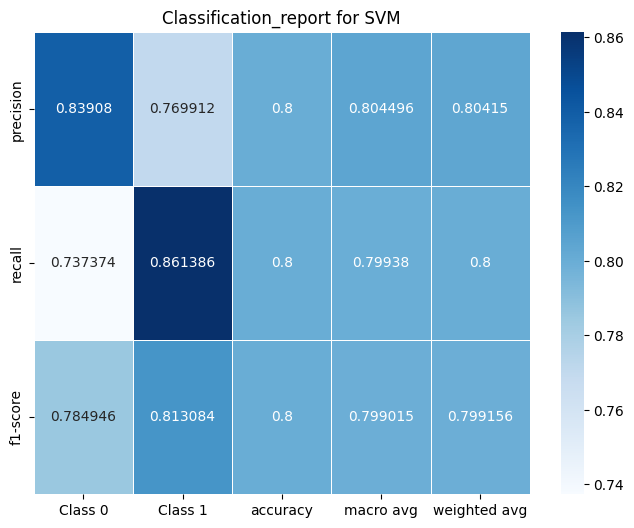

In [36]:
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(svm_report).iloc[:-1, :], annot=True, cmap = 'Blues', fmt='g', linewidths=.5)
plt.title("Classification_report for SVM")
plt.show();

Logistic Regression

In [37]:
logreg_model = LogisticRegression(random_state = 42)
logreg_model.fit(X_train_scaled, y_train)
logreg_pred = logreg_model.predict(X_test_scaled)

In [38]:
logreg_accuracy = accuracy_score(y_test, logreg_pred)

In [39]:
logreg_report = classification_report(y_test, svm_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

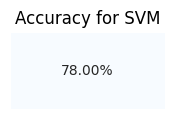

In [40]:
plt.figure(figsize=(2,1))
sns.heatmap([[logreg_accuracy]], annot=True, fmt = ".2%", cmap='Blues',cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title("Accuracy for SVM")
plt.show();

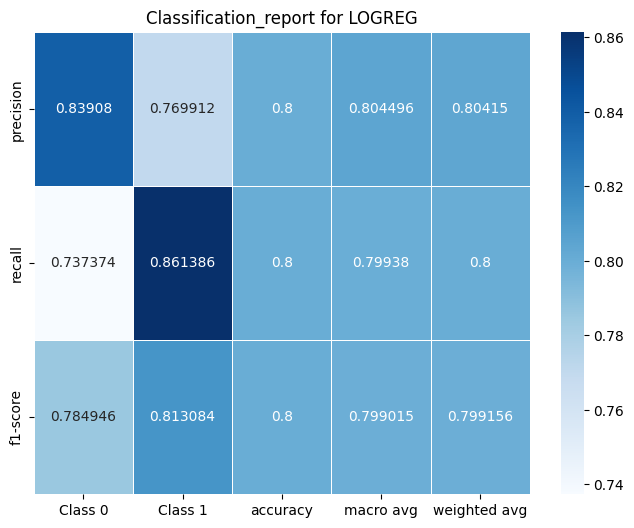

In [41]:
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(logreg_report).iloc[:-1, :], annot=True, cmap = 'Blues', fmt='g', linewidths=.5)
plt.title("Classification_report for LOGREG")
plt.show();

Naive Bayes

In [42]:
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)
nb_pred = nb_model.predict(X_test_scaled)


In [43]:
nb_accuracy = accuracy_score(y_test, nb_pred)

In [44]:
nb_report = classification_report(y_test, nb_pred, target_names = ["Class 0", "Class 1"], output_dict = True)

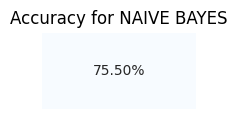

In [45]:
plt.figure(figsize=(2,1))
sns.heatmap([[nb_accuracy]], annot=True, fmt = ".2%", cmap='Blues',cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title("Accuracy for NAIVE BAYES")
plt.show();

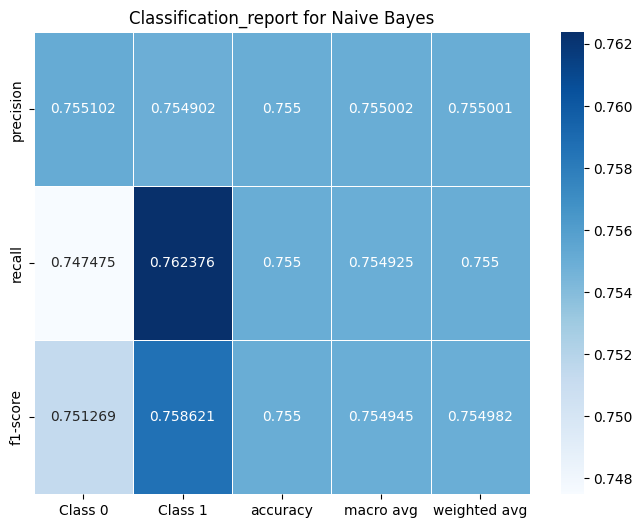

In [46]:
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(nb_report).iloc[:-1, :], annot=True, cmap = 'Blues', fmt='g', linewidths=.5)
plt.title("Classification_report for Naive Bayes")
plt.show();

Decision Trees

In [47]:
dt_model = DecisionTreeClassifier(random_state =42)
dt_model.fit(X_train_scaled, y_train)
dt_pred = dt_model.predict(X_test_scaled)

In [48]:
dt_accuracy = accuracy_score(y_test, dt_pred)

In [49]:
dt_report = classification_report(y_test, dt_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

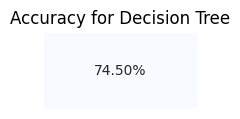

In [50]:
plt.figure(figsize=(2, 1))
sns.heatmap([[dt_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for Decision Tree')
plt.show()


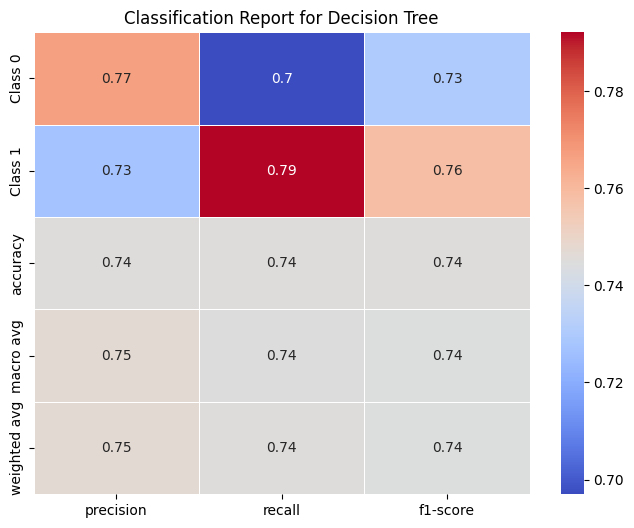

In [51]:
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(dt_report).iloc[:-1, :].T, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Classification Report for Decision Tree')
plt.show()

Gradient Boost Classifier

In [52]:
gb_model = GradientBoostingClassifier(random_state = 42)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)

In [53]:
gb_accuracy = accuracy_score(y_test, gb_pred)

In [54]:
gb_report = classification_report(y_test, gb_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

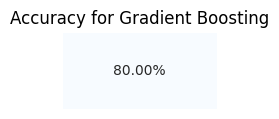

In [55]:
plt.figure(figsize=(2, 1))
sns.heatmap([[gb_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for Gradient Boosting')
plt.show()

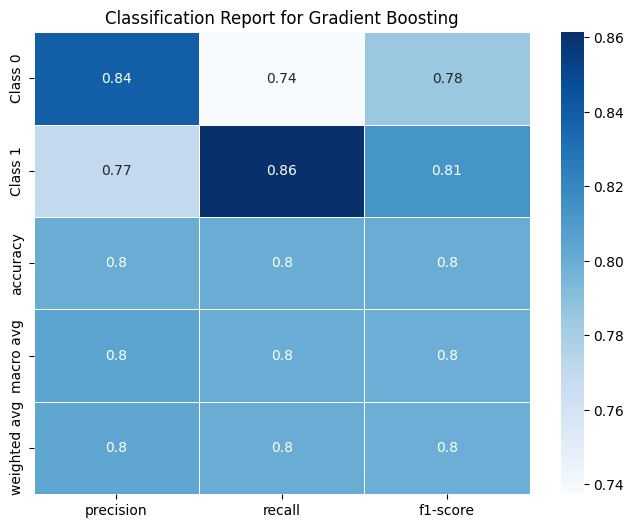

In [56]:
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(gb_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for Gradient Boosting')
plt.show()

XGBoost

In [57]:
xgb_model = XGBClassifier(random_state = 42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)

In [58]:
xgb_accuracy = accuracy_score(y_test, xgb_pred)

In [59]:
xgb_report = classification_report(y_test, xgb_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

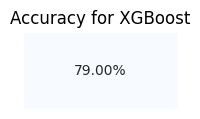

In [60]:
plt.figure(figsize=(2, 1))
sns.heatmap([[xgb_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for XGBoost')
plt.show();


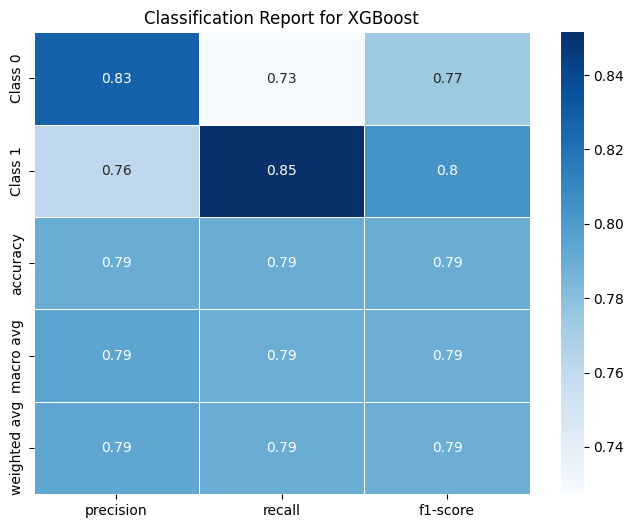

In [61]:
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(xgb_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for XGBoost')
plt.show()